# Privacy-Preserving Record Linkage (PPRL): Investigating Dataset Extension Attacks

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import hickle as hkl
import numpy as np
import string
import sys
from tqdm.notebook import tqdm

from graphMatching.gma import run_gma

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:20:01) [Clang 18.1.8 ]
PyTorch version 2.1.2
Torchvision version 0.16.2
Numpy version 1.24.4
Pandas version 2.0.3


## Run GMA

In [2]:
# Parameters
GLOBAL_CONFIG = {
    "Data": "./graphMatching/data/fakename_5k.tsv",
    "Overlap": 0.8,
    "DropFrom": "Both",
    "DevMode": False,  # Development Mode, saves some intermediate results to the /dev directory
    "BenchMode": False,  # Benchmark Mode
    "Verbose": True,  # Print Status Messages?
    "MatchingMetric": "cosine",
    "Matching": "MinWeight",
    "Workers": -1,
    "SaveAliceEncs": False,
    "SaveEveEncs": False
}

ENC_CONFIG = {
    "AliceAlgo": "BloomFilter",
    "AliceSecret": "SuperSecretSalt1337",
    "AliceN": 2,
    "AliceMetric": "dice",
    "EveAlgo": "BloomFilter",
    "EveSecret": "ATotallyDifferentString42",
    "EveN": 2,
    "EveMetric": "dice",
    # For BF encoding
    "AliceBFLength": 1024,
    "AliceBits": 10,
    "AliceDiffuse": False,
    "AliceT": 10,
    "AliceEldLength": 1024,
    "EveBFLength": 1024,
    "EveBits": 10,
    "EveDiffuse": False,
    "EveT": 10,
    "EveEldLength": 1024,
    # For TMH encoding
    "AliceNHash": 1024,
    "AliceNHashBits": 64,
    "AliceNSubKeys": 8,
    "Alice1BitHash": True,
    "EveNHash": 1024,
    "EveNHashBits": 64,
    "EveNSubKeys": 8,
    "Eve1BitHash": True,
    # For 2SH encoding
    "AliceNHashFunc": 10,
    "AliceNHashCol": 1000,
    "AliceRandMode": "PNG",
    "EveNHashFunc": 10,
    "EveNHashCol": 1000,
    "EveRandMode": "PNG",
    # For PST Encoding
    "AlicePSTK": 20,
    "AlicePSTL": 8,
    "AlicePSTP": None,
    "AliceCharset": string.printable,
    "EvePSTK": 20,
    "EvePSTL": 8,
    "EvePSTP": None,
    "EveCharset": string.printable
}

EMB_CONFIG = {
    "Algo": "Node2Vec",
    "AliceQuantile": 0.9,
    "AliceDiscretize": False,
    "AliceDim": 128,
    "AliceContext": 10,
    "AliceNegative": 1,
    "AliceNormalize": True,
    "EveQuantile": 0.9,
    "EveDiscretize": False,
    "EveDim": 128,
    "EveContext": 10,
    "EveNegative": 1,
    "EveNormalize": True,
    # For Node2Vec
    "AliceWalkLen": 100,
    "AliceNWalks": 20,
    "AliceP": 250,
    "AliceQ": 300,
    "AliceEpochs": 5,
    "AliceSeed": 42,
    "EveWalkLen": 100,
    "EveNWalks": 20,
    "EveP": 250,
    "EveQ": 300,
    "EveEpochs": 5,
    "EveSeed": 42
}

ALIGN_CONFIG = {
    "RegWS": max(0.1, GLOBAL_CONFIG["Overlap"]/2), #0005
    "RegInit":1, # For BF 0.25
    "Batchsize": 1, # 1 = 100%
    "LR": 200.0,
    "NIterWS": 100,
    "NIterInit": 5 ,  # 800
    "NEpochWS": 100,
    "LRDecay": 1,
    "Sqrt": True,
    "EarlyStopping": 10,
    "Selection": "None",
    "MaxLoad": None,
    "Wasserstein": True
}

In [3]:
reidentified_individuals, not_reidentified_individuals = run_gma(GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG, ALIGN_CONFIG)


Loading Alice's data
Encoding Alice's Data
Done encoding Alice's data
Computing Thresholds and subsetting data for Alice
Done processing Alice's data.
Loading Eve's data
Encoding Eve's Data
Done encoding Eve's data
Computing Thresholds and subsetting data for Eve
Done processing Eve's data.
Embedding Alice's data. This may take a while...


  0%|          | 0/83320 [00:00<?, ?it/s]

Epoch: 1	  Loss: 7787830.5
Epoch: 2	  Loss: 6680338.5
Epoch: 3	  Loss: 5757517.0
Epoch: 4	  Loss: 5151742.0
Epoch: 5	  Loss: 5142628.0
Done embedding Alice's data.
Embedding Eve's data. This may take a while...


  0%|          | 0/83340 [00:00<?, ?it/s]

Epoch: 1	  Loss: 7976018.5
Epoch: 2	  Loss: 6470012.5
Epoch: 3	  Loss: 5741505.0
Epoch: 4	  Loss: 5289154.0
Epoch: 5	  Loss: 4924996.0
Done embedding Eve's data.
Aligning vectors. This may take a while.

Computing initial mapping with convex relaxation...


100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Objective after convex initialization: 49.027809
Done [002 sec]

Computing mapping with Wasserstein Procrustes...


Iteration: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


epoch: 1  obj: 34.579  best: 34.579


Iteration: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


Objective of  34.578 is 71.75 % of initial value. Early stopping...
Done [275 sec]
Done.
Performing bipartite graph matching
Correct: 3333 of 3333
Success rate: 1.000000


In [6]:
df_reidentified_individuals = pd.DataFrame(reidentified_individuals[1:], columns=reidentified_individuals[0])
df_not_reidentified_individuals = pd.DataFrame(not_reidentified_individuals[1:], columns=not_reidentified_individuals[0])

In [10]:
print('Reidentified Individuals:')
print(df_reidentified_individuals.head())  
print('Not Reidentified Individuals:')
print(df_not_reidentified_individuals.head())

Reidentified Individuals:
  GivenName   Surname    Birthday  \
0     Donna  Anderson    1/7/2003   
1      Jean     Pusey   2/15/1999   
2     Doris      Cruz   9/16/1981   
3    Daniel      Hall   4/11/2002   
4    Audrey    Bowman  10/17/1959   

                                         bloomfilter    uid  
0  1001100000000100000001011000001011000000100010...  96474  
1  0010001010000010001000000010000100000000100000...  96607  
2  1001100000000000000000000000000000001110100010...  62154  
3  1000110000001000000001001000000010000010100010...  46041  
4  0000010010000100000101001010000000001100110100...  93172  
Not Reidentified Individuals:
                                         bloomfilter    uid
0  1000010011000000010100001110000011100110100011...  91327
1  0000100000000000000000011010000110000000110000...  81181
2  0001111000000101001000011100000000000000100010...  38719
3  0001100000001001010010110011100100100000100010...  81141
4  1000010010001000000000010000100010000100100000

## Define Dataset

In [11]:
class BloomFilterDataset(Dataset):
    def __init__(self, data, isLabeled=False, all_two_grams=None):
        self.isLabeled = isLabeled
        self.allTwoGrams = all_two_grams
        self.data = data  
        if self.isLabeled:
            # For reidentified data, extract labels (2-grams) from names
            self.data['label'] = self.data.apply(lambda row: self.extract_two_grams(row[0], row[1]), axis=1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        bloom_filter = self.data.iloc[idx]['bloomfilter']
        bloom_filter_tensor = self.bloomfilter_to_tensor(bloom_filter)

        if self.isLabeled:
            label = self.data.iloc[idx]['label']
            label_tensor = self.label_to_tensor(label)
            return bloom_filter_tensor, label_tensor
        else:
            # For unlabeled data (not_reidentified_individuals.tsv), just return the Bloom Filter
            return bloom_filter_tensor
    
    def extract_two_grams(self, firstname, surname):
        full_name = f"{surname} {firstname}".replace('"', '').replace('.', '').replace('/', '').strip()
        full_name = full_name.lower()  # Normalize to lowercase for consistency
        return [full_name[i:i+2] for i in range(len(full_name)-1) if ' ' not in full_name[i:i+2]]
    
    def bloomfilter_to_tensor(self, bloom_filter_str):
        bloom_filter_array = np.array([int(bit) for bit in bloom_filter_str], dtype=np.float32)
        return torch.tensor(bloom_filter_array)
    
    def label_to_tensor(self, label_two_grams):
        label_vector = np.zeros(len(self.allTwoGrams), dtype=np.float32)
        
        # Set 1 for the 2-grams present in the name
        for gram in label_two_grams:
            if gram in self.allTwoGrams:
                index = self.allTwoGrams.index(gram)
                label_vector[index] = 1
        
        return torch.tensor(label_vector)

## Create Datasets 

In [12]:
#Generate all 2-grams
alphabet = string.ascii_lowercase
all_two_grams = []
for a in alphabet:
    for b in alphabet:
        all_two_grams.append(a+b)
# Get a dictionary associating each 2-gram with an index
two_gram_dict = {i: two_gram for i, two_gram in enumerate(all_two_grams)}
# Create Datasets
data_labeled = BloomFilterDataset(df_reidentified_individuals, isLabeled=True, all_two_grams=all_two_grams)
data_not_labeled = BloomFilterDataset(df_not_reidentified_individuals, isLabeled=False, all_two_grams=all_two_grams)
bloomfilter_length = len(data_labeled[0][0])

## Create Dataloader

In [21]:
# Split proportions
train_size = int(0.8 * len(data_labeled))  # 80% training
val_size = len(data_labeled) - train_size  # 20% validation

# Split dataset
data_train, data_val = random_split(data_labeled, [train_size, val_size])
dataloader_train = DataLoader(data_train, batch_size=16, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=16, shuffle=True)
dataloader_test = DataLoader(data_not_labeled, batch_size=16, shuffle=False)

## Pytorch Model

In [29]:
class BloomFilterToTwoGramClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_two_grams=676):
        super(BloomFilterToTwoGramClassifier, self).__init__()
        
        # Define the layers for multi-label classification of 2-grams
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),   # Input => first hidden layer
            nn.ReLU(),                       
            nn.Dropout(0.2),                  
            nn.Linear(hidden_dim, hidden_dim),  # First hidden layer => second hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),  # First hidden layer => second hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),  # First hidden layer => second hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_two_grams), # Second hidden layer => output layer
            nn.Sigmoid()                       
        )

    def forward(self, x):
        # Forward pass through the model
        output = self.model(x)
        return output

In [30]:
model = BloomFilterToTwoGramClassifier(input_dim=bloomfilter_length)

## Training Loop

In [31]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [32]:
# Number of epochs
num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for bloom_filters, labels in tqdm(dataloader_train, desc="Training loop"):
        # Move data to device
        bloom_filters, labels = bloom_filters.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(bloom_filters)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(dataloader_train.dataset)
    train_losses.append(train_loss)

    #Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for bloom_filters, labels in tqdm(dataloader_val, desc="Validation loop"):
            # Move data to device
            bloom_filters, labels = bloom_filters.to(device), labels.to(device)
            
            outputs = model(bloom_filters)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
        val_loss = running_loss / len(dataloader_val.dataset)
        val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 1/30 - Train loss: 0.7018, Validation loss: 0.6931


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 2/30 - Train loss: 0.6931, Validation loss: 0.6931


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 3/30 - Train loss: 0.6931, Validation loss: 0.6931


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 4/30 - Train loss: 0.6931, Validation loss: 0.6931


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 5/30 - Train loss: 0.6931, Validation loss: 0.6931


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 6/30 - Train loss: 0.6931, Validation loss: 0.6931


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 7/30 - Train loss: 0.6931, Validation loss: 0.6931


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Visualize Losses

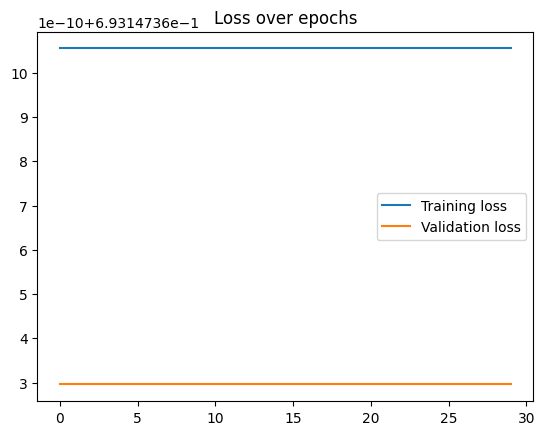

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Testing Area

In [ ]:
# First entry for reference (labeled data):
# surname                                                  Hegarty
# firstname                                    Miss. Hanora "Nora"
# bloomfilter    0000000010100011000100000101000000000000100000001000000000100111011000001001100100000100000000001000000000000000001000100000000000010010000000000000100010001110110111000000000000100000000100000001010000000000100101000011000010001010000001000000000000000000001000011010011001000100000011100100000000000011000100100000110011000000000010000000000010000000000000110000000110000000000010000000011100000001000000100000001100101011001000000000010000001000000000001000010110110000000001001000100001010111010000000010000000111000000000010010110000000000001000000101010001000000001000001000010000100110000111001110000000001010011110000100000000000100000001100001100000000000010000000000000000000000100000000010000001000000000011100000000000001000101000010100001001000011000000000010001100000000100000001000001000000000100000101000000000000000000010000000100000000100001000000100000000000000011100000001001000000001100010000001000001000000000000010100100000000110101110010000010000010100000000011000001000000001110000101001000010101111
# uid                                                          654
# Name: 0, dtype: object
#print('Length Labeled data:', len(data_labeled))
#print('Length Unlabeled data:', len(data_not_labeled))

#bloomfilter_tensor, label_tensor = data_labeled[0]

#print('Bloom Filter Tensor:', bloomfilter_tensor)
#print('Bloom Filter Tensor Shape:', bloomfilter_tensor.shape)
#print('Label Tensor:', label_tensor)
#print('Label Tensor Shape:', label_tensor.shape)

#for bloomfilter_tensors, label_tensors in dataloader_train:
#    print('Bloom Filter Tensor Shape:', bloomfilter_tensors.shape)
#    print('Label Tensor Shape:', label_tensors.shape)
#    print(label_tensors)
#    break

#print(str(model)[:500])
#example_bloom, example_label = data_train[0]
#example_out = model(example_bloom)
#print(example_out.shape) 
#loss_function_applied = criterion(example_out, example_label)
#print(loss_function_applied)
#print(example_out)

print(data_labeled[0])
 
# Apply model
result = model(bloomfilter_tensor)
# Result = Tensor of shape 676 with prob. for each 2gram
two_gram_scores = {two_gram_dict[i]: score.item() for i, score in enumerate(result)}

threshold = 0.000000001
filtered_two_gram_scores = {two_gram: score for two_gram, score in two_gram_scores.items() if score > threshold}
filtered_two_gram_scores